# Threat Catalogue Generation

This notebook shows the process of creating a threat catalogue based on the publicly available CVE and CWE datasets.

## Table of contents:
1. [Load CVE and CWE data](#load_cve_cwe_data)
    1. [CVE Parsing](#cve_parsing)
    2. [CWE Parsing (Specific Weaknesses)](#cwe_parsing)
    3. [CWE Parsing (Weakness Categories)](#cwe_parsing_category)
2. [Merge CVE and CWE DataFrames](#merge_cve_cwe)
    1. [Preprocessing](#cve_cwe_preprocessing)
    2. [Merge DataFrames](#cve_cwe_merge)
    3. [Inspection of the combined DataFrame](#analyze_merged_dataframe)
3. [STRIDE Mapping](#stride_mapping)
    1. [Using CWE Common Consequences Scope](#cc_scope_mapping)
    2. [Using CWE Common Consequences Impact](#cc_impact_mapping)
    3. [Visualize the created mapping](#plot_mapping)
4. [Text Classification](#text_classification)
    1. [Preprocessing](#text_classification_preprocessing)
    2. [Model Comparison](#text_classification_model_comparison)
    3. [Hyper-parameter Optimization](#text_classification_hyperparameter_optimization)
    4. [Evaluation](#text_classification_evaluation)
    5. [Completion of the Dataset](#test_classification_completion)
5. [Table Reduction](#table_reduction)
    1. [Attribute Encoding](#attribute_encoding)
    2. [Generate Table](#generate_table)

## 1. Load CVE and CWE data <a class="anchor" id="load_cve_cwe_data"></a>
In this section the CVE and CWE datasets get processed and saved into a pandas DataFrame to reuse them in the later steps.<br>
To reproduce this step all CVE JSON files need to be in the "./data/cve/" subdirectory. The needed files can be downloaded from the <a href="https://nvd.nist.gov/vuln/data-feeds#JSON_FEED"> National Vulnerability Database</a>.<br>
Additionally the CWE "Development Concepts" and "Research Concepts" datasets need to be placed in the "./data/cwe/" subdirectory. These files can be downloaded from <a href="https://cwe.mitre.org/data/downloads.html">MITRE</a> and need to be renamed into "CWE_Research_Concepts.xml" and "CWE_Development_Concepts.xml"

### 1.A. CVE Parsing <a class="anchor" id="cve_parsing"></a>
<i>Note: For better performance all data is first saved into a dictionary, which is later transformed into a pandas DataFrame</i>

In [1]:
import json
import glob
import pandas as pd

In [2]:
# get all cve json files
cve_data_dir = './data/cve/'
cve_files = glob.glob(cve_data_dir + '*.json')
print('Found {} JSON files in the \"{}\" directory'.format(
    len(cve_files), cve_data_dir))

Found 18 JSON files in the "./data/cve/" directory


In [3]:
# the prototype dictionary is used to ensure all rows later contain the same structure,
# which is needed for a correct transformation into a DataFrame
row_prototype = {
    # General Info
    'cve_id': '',
    'cve_data_type': '',
    'cve_data_format': '',
    'cve_data_version': '',
    'cve_published_date': '',
    'cve_last_modified_date': '',
    'cve_description': '',
    # CWE Info:
    'cwe_list': [],
    # CPE Info:
    'cpe_list': [],
    # CVSS Scoring V2
    'has_cvssV2_scoring': False,
    'cvssV2_version': '',
    'cvssV2_vector_string': '',
    'cvssV2_access_vector': '',
    'cvssV2_access_complexity': '',
    'cvssV2_authentication': '',
    'cvssV2_confidentiality_impact': '',
    'cvssV2_integrity_impact': '',
    'cvssV2_availability_impact': '',
    'cvssV2_base_score': '',
    'cvssV2_severity': '',
    'cvssV2_exploitability_score': '',
    'cvssV2_impact_score': '',
    'cvssV2_obtain_all_privilege': '',
    'cvssV2_obtain_user_privilege': '',
    'cvssV2_obtain_other_privilege': '',
    'cvssV2_user_interaction_required': '',
    # CVSS Scoring V3
    'has_cvssV3_scoring': False,
    'cvssV3_version': '',
    'cvssV3_vector_string': '',
    'cvssV3_attack_vector': '',
    'cvssV3_attack_complexity': '',
    'cvssV3_privileges_required': '',
    'cvssV3_user_interaction_required': '',
    'cvssV3_scope': '',
    'cvssV3_confidentiality_impact': '',
    'cvssV3_integrity_impact': '',
    'cvssV3_availability_impact': '',
    'cvssV3_base_score': '',
    'cvssV3_base_severity': '',
    'cvssV3_exploitability_score': '',
    'cvssV3_impact_score': '',
}

In [4]:
df_dict = {}
ct_dict = 0

for f in cve_files:
    print('processing file \"{}\"'.format(f))
    data = json.load(open(f, 'r'))

    for i in range(len(data['CVE_Items'])):
        # Create one row in our DataFrame for each CVE by extracting the following values from the json strucutre
        new_row = row_prototype.copy()

        tmp_data = data['CVE_Items'][i]

        # extract general information
        new_row['cve_id'] = tmp_data['cve']['CVE_data_meta']['ID']
        new_row['cve_data_type'] = tmp_data['cve']['data_type']
        new_row['cve_data_format'] = tmp_data['cve']['data_format']
        new_row['cve_data_version'] = tmp_data['cve']['data_version']
        new_row['cve_published_date'] = tmp_data['publishedDate']
        new_row['cve_last_modified_date'] = tmp_data['lastModifiedDate']
        new_row['cve_description'] = tmp_data['cve']['description']['description_data'][0]['value']

        # extract all CWEs
        cwe_list = []
        for cwe_item in range(len(tmp_data['cve']['problemtype']['problemtype_data'])):
            cwe_list.extend([i['value'] for i in tmp_data['cve']['problemtype']
                             ['problemtype_data'][cwe_item]['description']])

        new_row['cwe_list'] = cwe_list

        # extract all CPEs
        cpe_list = []
        if len(tmp_data['configurations']['nodes']) > 0:
            for cpe_nodes in range(len(tmp_data['configurations']['nodes'])):
                if 'cpe_match' in tmp_data['configurations']['nodes'][cpe_nodes].keys():
                    cpe_list.extend([(i['cpe23Uri'], ) for i in tmp_data['configurations']
                                     ['nodes'][cpe_nodes]['cpe_match'] if i['vulnerable'] == True])

        new_row['cpe_list'] = cpe_list

        # extract all CVSSv2 Metrics
        if 'baseMetricV2' in tmp_data['impact'].keys():
            new_row['has_cvssV2_scoring'] = True
            new_row['cvssV2_version'] = tmp_data['impact']['baseMetricV2']['cvssV2']['version']
            new_row['cvssV2_vector_string'] = tmp_data['impact']['baseMetricV2']['cvssV2']['vectorString']
            new_row['cvssV2_access_vector'] = tmp_data['impact']['baseMetricV2']['cvssV2']['accessVector']
            new_row['cvssV2_access_complexity'] = tmp_data['impact']['baseMetricV2']['cvssV2']['accessComplexity']
            new_row['cvssV2_authentication'] = tmp_data['impact']['baseMetricV2']['cvssV2']['authentication']
            new_row['cvssV2_confidentiality_impact'] = tmp_data['impact']['baseMetricV2']['cvssV2']['confidentialityImpact']
            new_row['cvssV2_integrity_impact'] = tmp_data['impact']['baseMetricV2']['cvssV2']['integrityImpact']
            new_row['cvssV2_availability_impact'] = tmp_data['impact']['baseMetricV2']['cvssV2']['availabilityImpact']
            new_row['cvssV2_base_score'] = tmp_data['impact']['baseMetricV2']['cvssV2']['baseScore']
            new_row['cvssV2_severity'] = tmp_data['impact']['baseMetricV2']['severity']
            new_row['cvssV2_exploitability_score'] = tmp_data['impact']['baseMetricV2']['exploitabilityScore']
            new_row['cvssV2_impact_score'] = tmp_data['impact']['baseMetricV2']['impactScore']
            new_row['cvssV2_obtain_all_privilege'] = tmp_data['impact']['baseMetricV2']['obtainAllPrivilege']
            new_row['cvssV2_obtain_user_privilege'] = tmp_data['impact']['baseMetricV2']['obtainUserPrivilege']
            new_row['cvssV2_obtain_other_privilege'] = tmp_data['impact']['baseMetricV2']['obtainOtherPrivilege']
            if 'userInteractionRequired' in tmp_data['impact']['baseMetricV2'].keys():
                new_row['cvssV2_user_interaction_required'] = tmp_data['impact']['baseMetricV2']['userInteractionRequired']

        # extract all CVSSv3 Metrics
        if 'baseMetricV3' in tmp_data['impact'].keys():
            new_row['has_cvssV3_scoring'] = True
            if 'cvssV3' in tmp_data['impact']['baseMetricV3'].keys():
                new_row['cvssV3_version'] = tmp_data['impact']['baseMetricV3']['cvssV3']['version']
                new_row['cvssV3_vector_string'] = tmp_data['impact']['baseMetricV3']['cvssV3']['vectorString']
                new_row['cvssV3_attack_vector'] = tmp_data['impact']['baseMetricV3']['cvssV3']['attackVector']
                new_row['cvssV3_attack_complexity'] = tmp_data['impact']['baseMetricV3']['cvssV3']['attackComplexity']
                new_row['cvssV3_privileges_required'] = tmp_data['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
                new_row['cvssV3_user_interaction_required'] = tmp_data['impact']['baseMetricV3']['cvssV3']['userInteraction']
                new_row['cvssV3_scope'] = tmp_data['impact']['baseMetricV3']['cvssV3']['scope']
                new_row['cvssV3_confidentiality_impact'] = tmp_data['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
                new_row['cvssV3_integrity_impact'] = tmp_data['impact']['baseMetricV3']['cvssV3']['integrityImpact']
                new_row['cvssV3_availability_impact'] = tmp_data['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
                new_row['cvssV3_base_score'] = tmp_data['impact']['baseMetricV3']['cvssV3']['baseScore']
                new_row['cvssV3_base_severity'] = tmp_data['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            if 'exploitabilityScore' in tmp_data['impact']['baseMetricV3'].keys():
                new_row['cvssV3_exploitability_score'] = tmp_data['impact']['baseMetricV3']['exploitabilityScore']
            if 'impactScore' in tmp_data['impact']['baseMetricV3'].keys():
                new_row['cvssV3_impact_score'] = tmp_data['impact']['baseMetricV3']['impactScore']

        df_dict[ct_dict] = new_row
        ct_dict += 1

cve_df = pd.DataFrame.from_dict(df_dict, "index")
print('Loaded {} CVE entries.'.format(len(cve_df)))

processing file "./data/cve/nvdcve-1.1-2010.json"
processing file "./data/cve/nvdcve-1.1-2009.json"
processing file "./data/cve/nvdcve-1.1-2012.json"
processing file "./data/cve/nvdcve-1.1-2017.json"
processing file "./data/cve/nvdcve-1.1-2002.json"
processing file "./data/cve/nvdcve-1.1-2004.json"
processing file "./data/cve/nvdcve-1.1-2005.json"
processing file "./data/cve/nvdcve-1.1-2015.json"
processing file "./data/cve/nvdcve-1.1-2007.json"
processing file "./data/cve/nvdcve-1.1-2006.json"
processing file "./data/cve/nvdcve-1.1-2016.json"
processing file "./data/cve/nvdcve-1.1-2014.json"
processing file "./data/cve/nvdcve-1.1-2008.json"
processing file "./data/cve/nvdcve-1.1-2018.json"
processing file "./data/cve/nvdcve-1.1-2013.json"
processing file "./data/cve/nvdcve-1.1-2011.json"
processing file "./data/cve/nvdcve-1.1-2019.json"
processing file "./data/cve/nvdcve-1.1-2003.json"
Loaded 136486 CVE entries.


### 1.B. CWE Parsing (Specific Weaknesses)<a class="anchor" id="cwe_parsing"></a>

In [5]:
import xml.etree.ElementTree as ET

cwe_data_dir = './data/cwe/'
cwe_file_name = 'CWE_Research_Concepts.xml'
etree = ET.parse(open(cwe_data_dir + cwe_file_name))
cwe_xml = etree.getroot()
weaknesses = cwe_xml[0]

In [6]:
row_prototype = {
    # Weakness attributes
    'id': None,
    'name': None,
    'abstraction': None,
    'structure': None,
    'status': None,
    # weakness children
    'description': None,
    'extended_description': None,
    'related_weaknesses': [],
    # applicable_platforms is split into multiple columns:
    'applicable_platforms_language': None,
    'applicable_platforms_paradigm': None,
    'applicable_platforms_technology': None,
    'applicable_platforms_operating_system': None,
    'background_details': None,
    'modes_of_introduction': None,
    'likelihood_of_exploit': None,
    # common_consequences is split in multiple columns:
    'common_consequences_scope': None,
    'common_consequences_impact': None,
    'common_consequences_note': None,
    'weakness_ordinalities': None,
    'alternate_terms': None,
    'taxonomy_mappings': None,
    'related_attack_patterns': None,
    'affected_resources': None,
    'functional_areas': None
}

In [7]:
def clear_child_name(child_name):
    return child_name.replace('{http://cwe.mitre.org/cwe-6}', '')

In [8]:
df_dict = {}
dict_ct = 0

for weakness in weaknesses:
    new_row = row_prototype.copy()

    new_row['id'] = int(weakness.attrib['ID'])
    new_row['name'] = weakness.attrib['Name']
    new_row['abstraction'] = weakness.attrib['Abstraction']
    new_row['structure'] = weakness.attrib['Structure']
    new_row['status'] = weakness.attrib['Status']

    for weakness_child in weakness.getchildren():
        child_name = clear_child_name(weakness_child.tag)

        if child_name == 'Description':
            new_row['description'] = weakness_child.text

        if child_name == 'Extended_Description':
            new_row['extended_description'] = weakness_child.text

        if child_name == 'Related_Weaknesses':
            related_weaknesses = []
            for related_weakness in weakness_child.getchildren():
                related_weaknesses.append(related_weakness.attrib)
            new_row['related_weaknesses'] = related_weaknesses

        if child_name == 'Applicable_Platforms':
            applicable_platforms_language = []
            applicable_platforms_paradigm = []
            applicable_platforms_technology = []
            applicable_platforms_operating_system = []

            for applicable_platform in weakness_child.getchildren():
                cleared_tag = clear_child_name(applicable_platform.tag)
                if cleared_tag == 'Language':
                    applicable_platforms_language.append(
                        applicable_platform.attrib)
                elif cleared_tag == 'Paradigm':
                    applicable_platforms_paradigm.append(
                        applicable_platform.attrib)
                elif cleared_tag == 'Technology':
                    applicable_platforms_technology.append(
                        applicable_platform.attrib)
                elif cleared_tag == 'Operating_System':
                    applicable_platforms_operating_system.append(
                        applicable_platform.attrib)

            new_row['applicable_platforms_language'] = applicable_platforms_language
            new_row['applicable_platforms_paradigm'] = applicable_platforms_paradigm
            new_row['applicable_platforms_technology'] = applicable_platforms_technology
            new_row['applicable_platforms_operating_system'] = applicable_platforms_operating_system

        if child_name == 'Background_Details':
            background_details = []
            for background_detail in weakness_child.getchildren():
                background_details.append(background_detail.text)
            new_row['background_details'] = background_details

        if child_name == 'Modes_Of_Introduction':
            modes_of_introduction = []
            for mode_of_introduction in weakness_child.getchildren():
                indroductions = {}
                for indroduction in mode_of_introduction.getchildren():
                    indroductions[clear_child_name(
                        indroduction.tag)] = indroduction.text
                modes_of_introduction.append(indroductions)
            new_row['modes_of_introduction'] = modes_of_introduction

        if child_name == 'Likelihood_Of_Exploit':
            new_row['likelihood_of_exploit'] = weakness_child.text

        if child_name == 'Common_Consequences':
            scope_consequences = []
            impact_consequences = []
            note_consequences = []
            for consequence in weakness_child.getchildren():
                for consequence_element in consequence.getchildren():
                    if clear_child_name(consequence_element.tag) == 'Scope':
                        scope_consequences.append(consequence_element.text)
                    elif clear_child_name(consequence_element.tag) == 'Impact':
                        impact_consequences.append(consequence_element.text)
                    elif clear_child_name(consequence_element.tag) == 'Note':
                        note_consequences.append(consequence_element.text)

            new_row['common_consequences_scope'] = scope_consequences
            new_row['common_consequences_impact'] = impact_consequences
            new_row['common_consequences_note'] = note_consequences

        if child_name == 'Weakness_Ordinalities':
            ordinalities = []
            for ordinality in weakness_child.getchildren():
                for ordinality_element in ordinality.getchildren():
                    if clear_child_name(ordinality_element.tag) == 'Ordinality':
                        ordinalities.append(ordinality_element.text)
            new_row['weakness_ordinalities'] = ordinalities

        if child_name == 'Alternate_Terms':
            alternate_terms = []
            for alternate_term in weakness_child.getchildren():
                term_element = {}
                for alternate_term_element in alternate_term.getchildren():
                    term_element[clear_child_name(
                        alternate_term_element.tag)] = alternate_term_element.text
                alternate_terms.append(term_element)
            new_row['alternate_terms'] = alternate_terms

        if child_name == 'Taxonomy_Mappings':
            taxonomy_mappings = []
            for mapping in weakness_child.getchildren():
                mapping_entry = mapping.attrib
                for elements in mapping.getchildren():
                    mapping_entry[clear_child_name(
                        elements.tag)] = elements.text
                taxonomy_mappings.append(mapping_entry)
            new_row['taxonomy_mappings'] = taxonomy_mappings

        if child_name == 'Related_Attack_Patterns':
            capec_id_list = []
            for related_attack in weakness_child.getchildren():
                capec_id_list.append(int(related_attack.attrib['CAPEC_ID']))
            new_row['related_attack_patterns'] = capec_id_list

        if child_name == 'Affected_Resources':
            affected_ressources = []
            for affected_ressource in weakness_child.getchildren():
                affected_ressources.append(affected_ressource.text)
            new_row['affected_resources'] = affected_ressources

        if child_name == 'Functional_Areas':
            functional_areas = []
            for functional_area in weakness_child.getchildren():
                functional_areas.append(functional_area.text)
            new_row['functional_areas'] = functional_areas

    df_dict[dict_ct] = new_row
    dict_ct += 1

cwe_df = pd.DataFrame.from_dict(df_dict, "index")
print('Loaded {} CWE entries.'.format(len(cwe_df)))

Loaded 808 CWE entries.


### 1.C. CWE Parsing (Weakness Categories)<a class="anchor" id="cwe_parsing_category"></a>

In [9]:
cwe_data_dir = './data/cwe/'
cwe_file_name = '/CWE_Development_Concepts.xml'
etree = ET.parse(open(cwe_data_dir + cwe_file_name))
cwe_xml = etree.getroot()

In [10]:
category_relation = []
categories = cwe_xml.getchildren()[1]  # Categories

# parse all categories
for category in categories.getchildren():
    category_id = category.attrib['ID']
    category_name = category.attrib['Name']
    category_decription = ""
    category_member = []

    for child in category.getchildren():
        if 'Summary' in child.tag:
            category_decription = child.text
        if 'Relationships' in child.tag:
            for member in child.getchildren():
                category_member.append(member.attrib['CWE_ID'])
    category_relation.append({'category_id': category_id,
                              'category_name': category_name,
                              'category_description': category_decription,
                              'category_member': category_member})

In [11]:
df_dict = {}
dict_ct = 0

row_prototype = dict.fromkeys(cwe_df.keys())
# generate new rows of each category and add them to the DataFrame
for category in category_relation:
    new_row = row_prototype.copy()
    row_prototype['id'] = category['category_id']
    row_prototype['name'] = category['category_name']
    row_prototype['abstraction'] = 'Category'
    row_prototype['description'] = category['category_description']

    member = []

    for m in category['category_member']:
        member.append({
            'Nature': 'ChildOf',
            'CWE_ID': m,
            'View_ID': '',
            'Ordinal': ''
        })

    row_prototype['related_weaknesses'] = member

    if not new_row['id'] == None:
        df_dict[dict_ct] = new_row
        dict_ct += 1

cwe_category_df = pd.DataFrame.from_dict(df_dict, "index")
print('Loaded {} CWE categories.'.format(len(cwe_category_df)))

Loaded 41 CWE categories.


<b>Add CWE Categorys to CWE-DataFrame</b>

In [12]:
cwe_df = cwe_df.append(cwe_category_df)
cwe_df.id = cwe_df.id.astype(int)

## 2. Merge CVE and CWE DataFrames<a class="anchor" id="merge_cve_cwe"></a>

### 2.A. Preprocessing<a class="anchor" id="cve_cwe_preprocessing"></a>

<b>Remove rejected CVEs</b>

In [13]:
length_all_cve = len(cve_df)
cve_df = cve_df[(~cve_df['cve_description'].str.contains('REJECT'))]
print('Removed {} rejected CVEs out of all {} CVEs'.format(
    length_all_cve - len(cve_df), length_all_cve))

Removed 7852 rejected CVEs out of all 136486 CVEs


<b>Expand CWE Entries of CVE-DataFrame</b>
<br>
Entries with more than one CWE get expanded, so each row can be identified by a unique tuple of (CVE, CWE).<br>
This step is needed to merge both datasets and for later processing steps.<br>

In [14]:
cve_df_one_cwe = cve_df[(cve_df['cwe_list'].str.len() == 1)]
cve_df_multiple_cwe = cve_df[(cve_df['cwe_list'].str.len() > 1)]
print("Out of all {} CVEs {} contain more than one CWE".format(
    len(cve_df), len(cve_df_multiple_cwe)))

Out of all 128634 CVEs 1430 contain more than one CWE


In [15]:
# Convert column 'cwe_list' from type list to type string
cve_df_one_cwe.loc[:, 'cwe_list'] = cve_df_one_cwe['cwe_list'].apply(''.join)

In [16]:
cve_expanded_df_dict = {}

i = 0
for idx, row in cve_df_multiple_cwe.iterrows():
    for cwe_item in row['cwe_list']:
        if cwe_item == 'NVD-CWE-noinfo':
            continue
        insertion_row = row.copy()
        insertion_row['cwe_list'] = cwe_item
        cve_expanded_df_dict[i] = insertion_row
        i += 1

cve_expanded_df = pd.DataFrame.from_dict(cve_expanded_df_dict, "index")
cve_df = cve_expanded_df.append(cve_df_one_cwe)

<b>Convert CWE-ID type</b><br>
Convert the 'cwe_id' column from type string to an integer. Therefore the prefix 'CWE-' has to be removed. e.g. Convert 'CWE-20' to '20'

In [17]:
def convert_cwe_id(cwe_string):
    if cwe_string[:4] == 'CWE-':
        return int(cwe_string[4:])
    else:
        return None


cve_df['cwe_id'] = cve_df['cwe_list'].apply(convert_cwe_id)

### 2.B. Merge DataFrames<a class="anchor" id="cve_cwe_merge"></a><br>
Both DataFrames get merged by using the unique 'cwe_id' identifier. To avoid overlapping column names, all columns from the CWE-DataFrame receive the 'cwe_' prefix.

In [18]:
df = cve_df.merge(cwe_df.add_prefix('cwe_'), how='left',
                  left_on='cwe_id', right_on='cwe_id')

### 2.C. Inspection of the combined DataFrame<a class="anchor" id="analyze_merged_dataframe"></a>

In [19]:
pd.set_option('max_columns', 66)
df.sample(5)

,cve_id,cve_data_type,cve_data_format,cve_data_version,cve_published_date,cve_last_modified_date,cve_description,cwe_list,cpe_list,has_cvssV2_scoring,cvssV2_version,cvssV2_vector_string,cvssV2_access_vector,cvssV2_access_complexity,cvssV2_authentication,cvssV2_confidentiality_impact,cvssV2_integrity_impact,cvssV2_availability_impact,cvssV2_base_score,cvssV2_severity,cvssV2_exploitability_score,cvssV2_impact_score,cvssV2_obtain_all_privilege,cvssV2_obtain_user_privilege,cvssV2_obtain_other_privilege,cvssV2_user_interaction_required,has_cvssV3_scoring,cvssV3_version,cvssV3_vector_string,cvssV3_attack_vector,cvssV3_attack_complexity,cvssV3_privileges_required,cvssV3_user_interaction_required,cvssV3_scope,cvssV3_confidentiality_impact,cvssV3_integrity_impact,cvssV3_availability_impact,cvssV3_base_score,cvssV3_base_severity,cvssV3_exploitability_score,cvssV3_impact_score,cwe_id,cwe_name,cwe_abstraction,cwe_structure,cwe_status,cwe_description,cwe_extended_description,cwe_related_weaknesses,cwe_applicable_platforms_language,cwe_applicable_platforms_paradigm,cwe_applicable_platforms_technology,cwe_applicable_platforms_operating_system,cwe_background_details,cwe_modes_of_introduction,cwe_likelihood_of_exploit,cwe_common_consequences_scope,cwe_common_consequences_impact,cwe_common_consequences_note,cwe_weakness_ordinalities,cwe_alternate_terms,cwe_taxonomy_mappings,cwe_related_attack_patterns,cwe_affected_resources,cwe_functional_areas
38553,CVE-2001-0699,CVE,MITRE,4.0,2001-09-20T04:00Z,2018-10-30T16:25Z,Buffer overflow in cb_reset in the System Serv...,NVD-CWE-Other,"[(cpe:2.3:o:sun:sunos:5.8:*:*:*:*:*:*:*,)]",True,2.0,AV:L/AC:L/Au:N/C:C/I:C/A:C,LOCAL,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,7.2,HIGH,3.9,10,True,False,False,False,False,,,,,,,,,,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117400,CVE-2013-0887,CVE,MITRE,4.0,2013-02-23T21:55Z,2017-09-19T01:35Z,The developer-tools process in Google Chrome b...,CWE-264,[],True,2.0,AV:N/AC:L/Au:N/C:P/I:P/A:P,NETWORK,LOW,NONE,PARTIAL,PARTIAL,PARTIAL,7.5,HIGH,10,6.4,False,False,False,False,False,,,,,,,,,,,,,,,264.0,"Permissions, Privileges, and Access Controls",Category,None,None,Weaknesses in this category are related to the...,None,"[{'Nature': 'ChildOf', 'CWE_ID': '265', 'View_...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
113069,CVE-2018-4956,CVE,MITRE,4.0,2018-07-09T19:29Z,2019-08-21T16:20Z,Adobe Acrobat and Reader versions 2018.011.200...,CWE-125,[],True,2.0,AV:N/AC:L/Au:N/C:P/I:N/A:N,NETWORK,LOW,NONE,PARTIAL,NONE,NONE,5,MEDIUM,10,2.9,False,False,False,False,True,3.0,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6,125.0,Out-of-bounds Read,Base,Simple,Draft,"The software reads data past the end, or befor...","Typically, this can allow attackers to read se...","[{'Nature': 'ChildOf', 'CWE_ID': '119', 'View_...","[{'Name': 'C', 'Prevalence': 'Undetermined'}, ...",[],[],[],None,[{'Phase': 'Implementation'}],None,"[Confidentiality, Confidentiality]","[Read Memory, Bypass Protection Mechanism]","[By reading out-of-bounds memory, an attacker ...",[Primary],None,"[{'Taxonomy_Name': 'PLOVER', 'Entry_Name': 'Ou...","[537, 540]",None,None
141343,CVE-2019-7353,CVE,MITRE,4.0,2019-05-17T17:29Z,2019-09-09T19:15Z,An Incorrect Access Control issue was discover...,CWE-284,[(cpe:2.3:a:gitlab:gitlab:*:*:*:*:community:*:...,True,2.0,AV:N/AC:L/Au:N/C:P/I:P/A:N,NETWORK,LOW,NONE,PARTIAL,PARTIAL,NONE,6.4,MEDIUM,10,4.9,False,False,False,False,True,3.0,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:N,NETWORK,LOW,NONE,NONE,UNCHANGED,HIGH,HIGH,NONE,9.1,CRITICAL,3.9,5.2,284.0,Improper Access Control,Class,Simple,Incomplete,The software does not restrict or incorrectly ...,\n,"[{'Nature': 'ChildOf', 'CWE_ID': '693', 'View_...",None,None,None,None,None,"[{'Phase': 'Architecture and Design'}, {'Phase...",None,[Other],[Varies by Context],[],None,"[{'Term': 'Authorization', 'D

In [21]:
print("Our dataset of {} rows of which {} have a unique CVE.".format(
    len(df), len(df['cve_id'].unique())))
print("Out of all rows {} rows have a CWE ({:.2f} %) (which also includes CWE-Categorys).".format(
    len(df[~df['cwe_id'].isnull()]), (len(df[~df['cwe_id'].isnull()])/len(df))*100))
print("The remaining {} rows have no CWE ({:.2f} %).".format(
    len(df[df['cwe_id'].isnull()]), (len(df[df['cwe_id'].isnull()])/len(df))*100))

print("The dataset contains {} unique CWEs.".format(
    len(df['cwe_id'].unique())-1))  # one nan-value is substracted

print("\nCWE Abstractions:")
cwe_abstraction_group = df.groupby('cwe_abstraction').count()['cve_id']
for i in cwe_abstraction_group.index:
    print("{:<10} {} ({:.2f}% of all rows)".format(
        i, cwe_abstraction_group[i], (cwe_abstraction_group[i]/len(df))*100))

Our dataset of 129675 rows of which 128524 have a unique CVE.
Out of all rows 93466 rows have a CWE (72.08 %) (which also includes CWE-Categorys).
The remaining 36209 rows have no CWE (27.92 %).
The dataset contains 170 unique CWEs.

CWE Abstractions:
Base       36987 (28.52% of all rows)
Category   15280 (11.78% of all rows)
Class      36518 (28.16% of all rows)
Compound   2603 (2.01% of all rows)
Variant    1839 (1.42% of all rows)


## 3. STRIDE Mapping <a class="anchor" id="stride_mapping"></a>

<b>Create STRIDE Columns</b>

In [22]:
stride_columns = "S,T,R,I,D,E".split(',')
for col in stride_columns:
    df[col] = None

### 3.A. Using CWE Common Consequences Scope <a class="anchor" id="cc_scope_mapping"></a>

In [23]:
mapping = {
    'Availability': 'D',      # Denial of Service
    'Confidentiality': 'I',   # Information disclosure
    'Integrity': 'T',         # Tampering
    'Non-Repudiation': 'R',   # Repudiation
    'Authentication': 'S',    # Spoofing
    'Accountability': 'R'     # Repudiation
}


def stride_scope_mapping(cwe_common_consequences_scope):
    result = {
        'S': False,
        'T': False,
        'R': False,
        'I': False,
        'D': False,
        'E': False,
    }

    if isinstance(cwe_common_consequences_scope, list):
        for c in cwe_common_consequences_scope:
            if c in mapping.keys():
                mapped_c = mapping[c]
                if mapped_c in result.keys():
                    result[mapped_c] = True

    return result.values()

In [24]:
df['S'], df['T'], df['R'], df['I'], df['D'], df['E'] = zip(
    *df['cwe_common_consequences_scope'].apply(stride_scope_mapping))

In [25]:
df[stride_columns].head(5)

,S,T,R,I,D,E
0,False,True,False,True,True,False
1,False,True,True,True,True,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,True,False,True,True,False


<b>Count rows containing given scope</b><br>
Some entries contain the same "scope" several times. Therefore, this separate function is created, which counts multiple entries per row just once, to count how many entries actually contain this scope.

In [27]:
scope_counter = {
    'Availability': 0,      # Denial of Service
    'Confidentiality': 0,   # Information disclosure
    'Integrity': 0,         # Tampering
    'Non-Repudiation': 0,   # Repudiation
    'Authentication': 0,    # Spoofing
    'Accountability': 0     # Repudiation
}

def count_rows_containing_scope(cwe_common_consequences_scope):
    scope_per_row = []
    
    if isinstance(cwe_common_consequences_scope, list):
        for c in cwe_common_consequences_scope:
            if c in scope_counter.keys():
                if not c in scope_per_row:
                    scope_counter[c] += 1
                    scope_per_row.append(c)
    
_ = df['cwe_common_consequences_scope'].apply(count_rows_containing_scope)

In [28]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(zip(scope_counter.keys(),scope_counter.values()), tablefmt='html')))

Availability,55240
Confidentiality,70996
Integrity,62755
Non-Repudiation,6378
Authentication,408
Accountability,76


### 3.B. Using CWE Common Consequences Impact <a class="anchor" id="cc_impact_mapping"></a>

In [29]:
df.loc[df['cwe_common_consequences_impact'].astype(str).str.contains(
    'Gain Privileges or Assume Identity'), 'E'] = True
df.loc[df['cwe_common_consequences_impact'].astype(str).str.contains(
    'Gain Privileges or Assume Identity'), 'S'] = True
df.loc[df['cwe_common_consequences_impact'].astype(str).str.contains(
    'Execute Unauthorized Code or Commands'), 'S'] = True
df.loc[df['cwe_common_consequences_impact'].astype(str).str.contains(
    'Execute Unauthorized Code or Commands'), 'E'] = True

<b>Count rows containing given impact</b><br>

In [30]:
for impact in ['Gain Privileges or Assume Identity', 'Execute Unauthorized Code or Commands']:
    print(impact,'\t', len(df[df['cwe_common_consequences_impact'].astype(str).str.contains(impact)]))

Gain Privileges or Assume Identity 	 10655
Execute Unauthorized Code or Commands 	 50333


### 3.C. Visualize the created mapping <a class="anchor" id="plot_mapping"></a>

The graph below shows for each row of the data set how many STRIDE Threats in the respective row could be identified by our mapping. This also shows that about 70,000 entries could not be assigned to a STRIDE Threat. These are the entries without a CWE or with a CWE category. These entries are classified later in the [text classification](#text_classification) step.

Text(0, 0.5, 'Affected Rows')

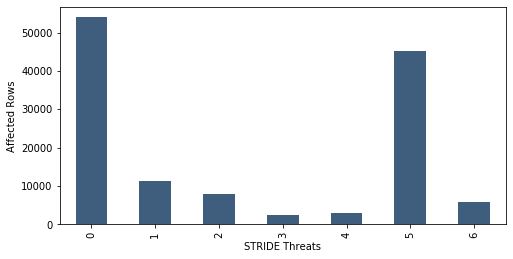

In [31]:
df['num_stride_threats'] = df[stride_columns].sum(axis=1)

ax = df.groupby(by='num_stride_threats').count()['cve_id'].plot(
    kind='bar', figsize=(8, 4), color='#3F5D7D')
ax.set_xlabel("STRIDE Threats")
ax.set_ylabel("Affected Rows")

The graph below shows how many rows were assigned to each STRIDE Threat by the mapping process.

Text(0, 0.5, 'Affected Rows')

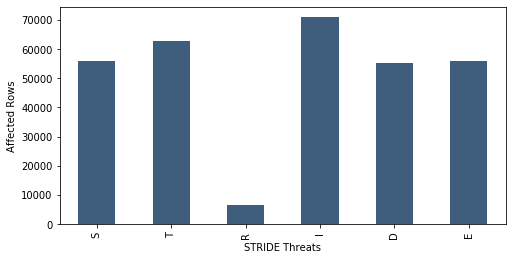

In [33]:
ax = df[['S', 'T', 'R', 'I', 'D', 'E']].sum().plot(
    kind='bar', figsize=(8, 4), color='#3F5D7D')
ax.set_xlabel("STRIDE Threats")
ax.set_ylabel("Affected Rows")

## 4. Text Classification <a class="anchor" id="text_classification"></a>

### 4.A. Preprocessing <a class="anchor" id="text_classification_preprocessing"></a>

In [35]:
from nltk.corpus import stopwords
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer

# lower all words in description
df['cve_description_preprocessed'] = df['cve_description'].apply(
    lambda x: " ".join(x.lower() for x in x.split()))
stop = stopwords.words('english')
# remove stop/filler words
df['cve_description_preprocessed'] = df['cve_description_preprocessed'].apply(
    lambda x: " ".join(x for x in x.split() if x not in stop))
# lemmatize all words
df['cve_description_preprocessed'] = df['cve_description_preprocessed'].apply(
    lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# create and fit the text vectorizer
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 2), max_features=5000)
tfidf_vectorizer.fit(df['cve_description_preprocessed'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

#### Create Training Dataset <a class="anchor" id="text_classification_preprocessing"></a>
We use all already classified rows from the DataFrame to create the training dataset<br>
The remaining rows (all rows that aren't classified so far) will be later classified using the created text classifier

In [37]:
train_df = df[df['num_stride_threats']>0].copy()
print("The training dataset contains {} entries".format(len(train_df)))

The training dataset contains 75721 entries


### 4.B. Model Comparison <a class="anchor" id="text_classification_model_comparison"></a>
In the following two steps we compare multiple machine-learning models by performing a 3-fold cross-validation .<br>
The results for our comparison can be seen in [the table below](#text_classification_model_comparison_results).<br>

In [38]:
# import classifiers dependencies
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb
# import scoring dependencies
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer

classifier_names = ['Naive Bayes', 'Logistic Regression',
                    'Decision Tree', 'Random Forest', 'LightGBM']

classifiers = [
    MultinomialNB(alpha=0.2),
    LogisticRegression(solver='sag', random_state=0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0),
    lgb.LGBMClassifier()
]

model_comparison_metrics = {
    'Naive Bayes': {},
    'Logistic Regression': {},
    'Decision Tree': {},
    'Random Forest': {},
    'LightGBM': {}
}


scoring = {'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
           }

In [39]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate

for target_column in ['S', 'T', 'R', 'I', 'D', 'E']:

    X = train_df['cve_description_preprocessed'].values
    y = train_df[target_column].values

    X, y = shuffle(X, y, random_state=0)

    X = tfidf_vectorizer.transform(X)

    for clf_name, clf in zip(classifier_names, classifiers):
        scores = cross_validate(
            clf, X, y, scoring=scoring, cv=3, return_train_score=True)
        model_comparison_metrics[clf_name][target_column] = scores

#### Model Comparison Results <a class="anchor" id="text_classification_model_comparison_results"></a>

In [40]:
from IPython.display import HTML, display
import tabulate

model_comparison_table = []
model_comparison_table.append(['Model', 'S', 'T', 'R', 'I', 'D', 'E', 'Avg']) # Table header

for classifier_name in model_comparison_metrics:
    
    table_row = [classifier_name]
    avg = 0
    for target in model_comparison_metrics[classifier_name]:
        table_row.append(round(model_comparison_metrics[classifier_name][target]['test_f1_score'].mean(),3))
        avg += model_comparison_metrics[classifier_name][target]['test_f1_score'].mean()
    table_row.append(round(avg/6, 3))
    model_comparison_table.append(table_row)

display(HTML(tabulate.tabulate(model_comparison_table, tablefmt='html')))

Model,S,T,R,I,D,E,Avg
Naive Bayes,0.932,0.938,0.699,0.966,0.932,0.932,0.9
Logistic Regression,0.952,0.96,0.755,0.978,0.953,0.952,0.925
Decision Tree,0.933,0.946,0.733,0.97,0.935,0.933,0.908
Random Forest,0.954,0.962,0.778,0.979,0.955,0.954,0.93
LightGBM,0.954,0.963,0.799,0.98,0.956,0.954,0.934


### 4.C. Hyper-parameter Optimization <a class="anchor" id="text_classification_hyperparameter_optimization"></a>
Our model comparison has shown that the LightGBM model seems to produce the best results.
We therefore perform a hyper-parameter optimization for this model by using a grid search algorithm on a predefined set of parameters.
Note: In order to reproduce the results of our mapping, this step can be skipped, as we restore the parameters found in the [following step](#text_classification_hyperparameter_optimization_results).<br>

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [42]:
optimized_parameters = {}

for target_column in ['S', 'T', 'R', 'I', 'D', 'E']:
    print(target_column)
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(
        train_df['cve_description_preprocessed'], train_df[target_column], random_state=0)

    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)

    param_grid = {'boosting_type': ['gbdt'],
                  'objective': ['binary'],
                  'num_iterations': [500, 1000],
                  'learning_rate': [0.005, 0.05],
                  'num_leaves': [512, 1024],
                  'feature_fraction': [0.5, 1.0],
                  'bagging_fraction': [0.5, 1.0]
                  }

    model = lgb.LGBMClassifier(boosting_type="gbdt", n_jobs=-1, silent=True)
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=1, scoring='f1')
    grid_result = grid.fit(X_train, y_train)

    optimized_parameters[target_column] = grid.best_params_

#### Hyperparameter Optimization Results <a class="anchor" id="text_classification_hyperparameter_optimization_results"></a>
We restore the found hyper-parameters here to allow a reproduction of our results without extensive computational effort.

In [43]:
optimized_parameters = {
    'S': {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.5, 'learning_rate': 0.005, 'num_iterations': 1000, 'num_leaves': 512, 'objective': 'binary'},
    'T': {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.5, 'learning_rate': 0.005, 'num_iterations': 1000, 'num_leaves': 512, 'objective': 'binary'},
    'R': {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.05, 'num_iterations': 500, 'num_leaves': 512, 'objective': 'binary'},
    'I': {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.005, 'num_iterations': 1000, 'num_leaves': 1024, 'objective': 'binary'},
    'D': {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.5, 'learning_rate': 0.005, 'num_iterations': 1000, 'num_leaves': 1024, 'objective': 'binary'},
    'E': {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.5, 'learning_rate': 0.005, 'num_iterations': 1000, 'num_leaves': 512, 'objective': 'binary'},
}

#### Retrain the models with optimized parameters
To allow a reproduction of our results without performing the whole hyper-parameter optimization step we retrain our models again with the found parameters. Additionally we calculate a variety of metrics to later evaluate our model and to calculate a desired threshold for our classification process.

In [44]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

classification_results = {}
for target_column in ['S', 'T', 'R', 'I', 'D', 'E']:
    print(target_column)
    X_train, X_test, y_train, y_test = train_test_split(
        train_df['cve_description_preprocessed'], train_df[target_column], random_state=0)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)

    results = {}
    # retrain a model with the best parameters
    
    clf = lgb.LGBMClassifier(**optimized_parameters[target_column] , n_jobs=-1, silent=True)
    clf.fit(X_train, y_train)

    predictions = clf.predict_proba(X_test)[:, 1]

    roc_fpr, roc_tpr, roc_threshold = roc_curve(y_test, predictions)
    roc_auc = auc(roc_fpr, roc_tpr)
    precision, recall, pr_threshold = precision_recall_curve(
        y_test, predictions)
    pr_auc = auc(recall, precision)

    results['classifier'] = clf
    results['roc_fpr'] = roc_fpr
    results['roc_tpr'] = roc_tpr
    results['roc_threshold'] = roc_threshold
    results['roc_auc'] = roc_auc
    results['precision'] = precision
    results['recall'] = recall
    results['pr_threshold'] = pr_threshold
    results['pr_auc'] = pr_auc
    results['f1_score'] = f1_score(y_test, predictions.round())
    results['precision_score'] = precision_score(y_test, predictions.round())
    results['recall_score'] = recall_score(y_test, predictions.round())
    results['y_true'] = y_test
    results['y_pred'] = predictions

    classification_results[target_column] = results

We output the f1-score of the optimized model to be able to compare the improvement with the model from the 
[model comparison](#text_classification_model_comparison_results).

In [45]:
evaluation_table = [['Metric','S', 'T', 'R', 'I', 'D', 'E']] # Table header

for metric in ['f1_score']:
    
    table_row = [metric]
    
    for target in classification_results:
        table_row.append(round(classification_results[target][metric],3))
    evaluation_table.append(table_row)

display(HTML(tabulate.tabulate(evaluation_table, tablefmt='html')))

Metric,S,T,R,I,D,E
f1_score,0.96,0.967,0.801,0.98,0.961,0.96


### 4.D. Evaluation <a class="anchor" id="text_classification_evaluation"></a>

#### Precision-Recall-Curve  <a class="anchor" id="text_classification_"></a>

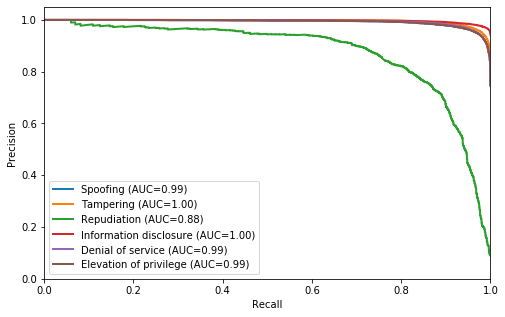

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
lw = 2

threat_type_dict = {
    'S':'Spoofing',
    'T':'Tampering',
    'R':'Repudiation',
    'I':'Information disclosure',
    'D':'Denial of service',
    'E':'Elevation of privilege'
}

for threat_type in classification_results:
    fpr = classification_results[threat_type]['recall']
    tpr = classification_results[threat_type]['precision']
    roc_auc = classification_results[threat_type]['pr_auc']
    plt.plot(fpr, tpr, lw=lw, label='%s (AUC=%0.2f)' % (threat_type_dict[threat_type], roc_auc))
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Precision')
plt.xlabel('Recall')
#plt.title('Precision-Recall curve for each threat')
plt.legend(loc="lower left")
plt.show()

#### Receiver operating characteristics curve  <a class="anchor" id="text_classification_"></a>

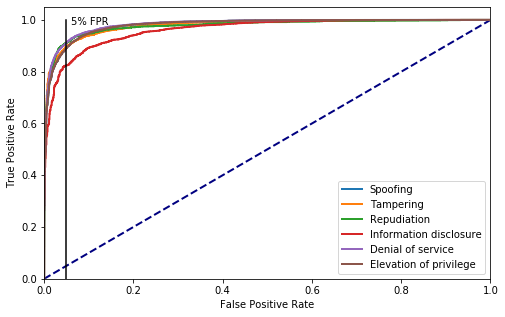

In [47]:
plt.figure(figsize=(8,5))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

threat_type_dict = {
    'S':'Spoofing',
    'T':'Tampering',
    'R':'Repudiation',
    'I':'Information disclosure',
    'D':'Denial of service',
    'E':'Elevation of privilege'
}


for threat_type in classification_results:
    fpr = classification_results[threat_type]['roc_fpr']
    tpr = classification_results[threat_type]['roc_tpr']
    roc_auc = classification_results[threat_type]['roc_auc']
    plt.plot(fpr, tpr, lw=lw, label='%s' % (threat_type_dict[threat_type]))

plt.plot([0.05,0.05], [0,1],color='k')
plt.annotate('5% FPR', [0.06, 0.98])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic for each threat')
plt.legend(loc="lower right")
plt.show()

#### Feature Importance  <a class="anchor" id="text_classification_"></a>

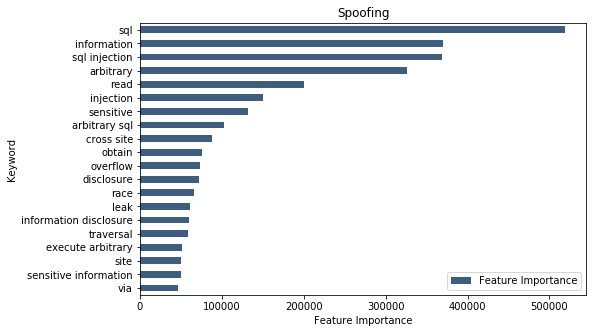

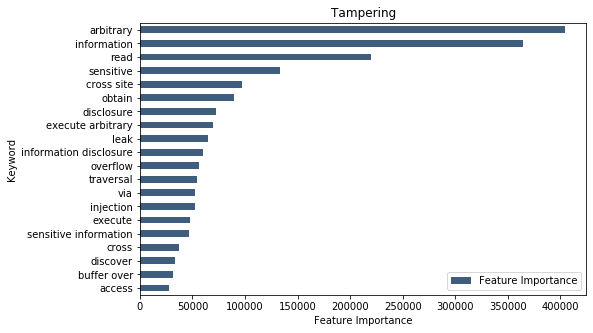

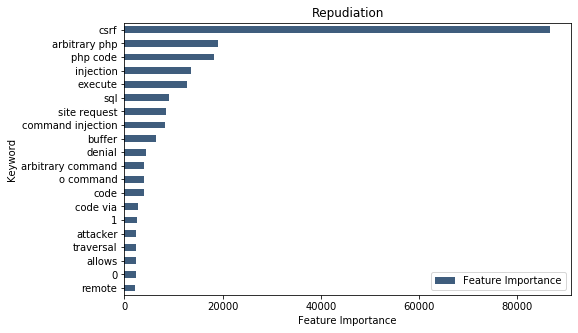

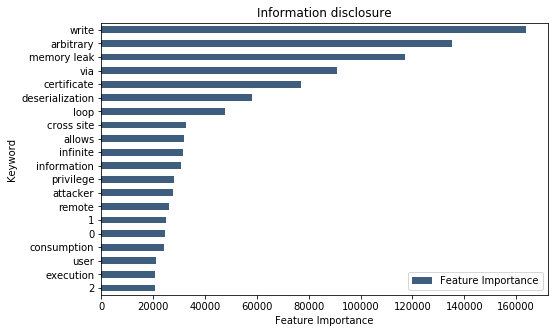

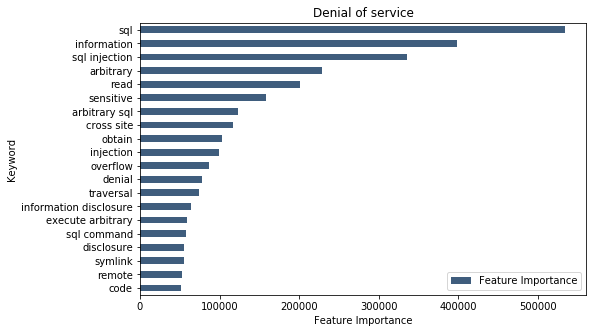

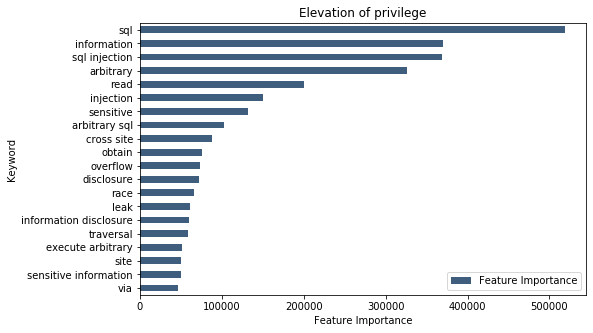

In [48]:
threat_type_dict = {
    'S': 'Spoofing',
    'T': 'Tampering',
    'R': 'Repudiation',
    'I': 'Information disclosure',
    'D': 'Denial of service',
    'E': 'Elevation of privilege'
}


for threat in classification_results.keys():
    feature_importance_df = pd.DataFrame(index=tfidf_vectorizer.get_feature_names(
    ), data=classification_results[threat]['classifier'].booster_.feature_importance(importance_type='gain'), columns=['Feature Importance'])
    ax = feature_importance_df.sort_values(by=['Feature Importance'], ascending=False).head(20).sort_values(by=['Feature Importance'], ascending=True).plot(
        kind='barh', title=threat_type_dict[threat], align='center', color='#3F5D7D', figsize=(8, 5))
    ax.set_xlabel("Feature Importance")
    ax.set_ylabel("Keyword")

#### Find  threshold  <a class="anchor" id="text_classification_find_threshold"></a>

In [49]:
def get_fpr(label, prediction):
    negative_samples = (label == 0).sum()
    false_positives = (prediction[label == 0] == 1).sum()
    return false_positives / float(negative_samples)

def get_tpr(label, prediction):
    positive_samples = (label == 1).sum()
    true_positives = (prediction[label==1]==1).sum()
    return true_positives/ float(positive_samples)

def find_threshold(label, prediction, desired_fpr):
    threshold = 0.0
    fpr = get_fpr(label, prediction > threshold)
    while fpr > desired_fpr and threshold < 1.0:
        threshold += 0.0001
        fpr = get_fpr(label, prediction > threshold)
    return threshold, fpr

In [50]:
threshold_dict = {}
desired_fpr = 0.05

for threat_type in classification_results:
    thresh, fpr = find_threshold(
        classification_results[threat_type]['y_true'], classification_results[threat_type]['y_pred'], desired_fpr)
    threshold_dict[threat_type] = thresh
    tpr = get_tpr(classification_results[threat_type]['y_true'],
                  classification_results[threat_type]['y_pred'] > thresh)
    print("The \"{}\" model generates a {} % false positive rate with a threshold of {:.3f} and generates a true positive rate of {:.3f} %".format(
        threat_type_dict[threat_type], desired_fpr*100, thresh, tpr*100))

The "Spoofing" model generates a 5.0 % false positive rate with a threshold of 0.859 and generates a true positive rate of 89.071 %
The "Tampering" model generates a 5.0 % false positive rate with a threshold of 0.902 and generates a true positive rate of 89.709 %
The "Repudiation" model generates a 5.0 % false positive rate with a threshold of 0.000 and generates a true positive rate of 90.761 %
The "Information disclosure" model generates a 5.0 % false positive rate with a threshold of 0.994 and generates a true positive rate of 82.322 %
The "Denial of service" model generates a 5.0 % false positive rate with a threshold of 0.839 and generates a true positive rate of 91.110 %
The "Elevation of privilege" model generates a 5.0 % false positive rate with a threshold of 0.859 and generates a true positive rate of 89.071 %


### 4.E. Completion of the Dataset  <a class="anchor" id="test_classification_completion"></a>
In this step we use the generated models to fill the gaps in our data set through the calculation.

In [51]:
df.loc[df['cwe_abstraction'].isnull(), 'cwe_abstraction'] = 'Text Classified'
df.loc[df['cwe_name'].isnull(), 'cwe_name'] = 'Text Classified'
df.loc[df['cwe_name'].isnull(), 'cwe_name'] = 'Text Classified'
df.loc[df['cwe_id'].isnull(), 'cwe_id'] = '-'

In [52]:
classify_df = df[(df['cwe_abstraction'] == 'Category') |
                 (df['cwe_abstraction'] == 'Text Classified')]
features = tfidf_vectorizer.transform(
    classify_df['cve_description_preprocessed'])

In [53]:
for threat in ['S', 'T', 'R', 'I', 'D', 'E']:
    # Load classifier for given threat
    clf = classification_results[threat]['classifier']
    # predict probability
    classify_df.loc[:,threat+'_pred'] = clf.predict_proba(features)[:,1]
    classify_df.loc[:,threat] = False
    # check if the probability is greater than the calculated thrshold
    classify_df.loc[classify_df[threat+'_pred'] > threshold_dict[threat]  ,threat] = True
    print('{} entries for the threat \"{}\" were identified.'.format(classify_df[threat].sum(), threat_type_dict[threat]))

31107 entries for the threat "Spoofing" were identified.
32426 entries for the threat "Tampering" were identified.
6830 entries for the threat "Repudiation" were identified.
35583 entries for the threat "Information disclosure" were identified.
28838 entries for the threat "Denial of service" were identified.
31107 entries for the threat "Elevation of privilege" were identified.


In [54]:
for threat in ['S', 'T', 'R', 'I', 'D', 'E']:
    df.loc[classify_df.index, threat] = classify_df[threat]

In [55]:
df.loc[classify_df.index][['S', 'T', 'R', 'I', 'D', 'E']].head()

,S,T,R,I,D,E
2,True,False,False,True,True,True
3,True,False,False,True,True,True
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,True,True,True,True,True,True


In [57]:
initial_stride_mapping = df[~df.index.isin(classify_df.index)][['S', 'T', 'R', 'I', 'D', 'E']].sum()
text_classification_stride_mapping = df[df.index.isin(classify_df.index)][['S', 'T', 'R', 'I', 'D', 'E']].sum()

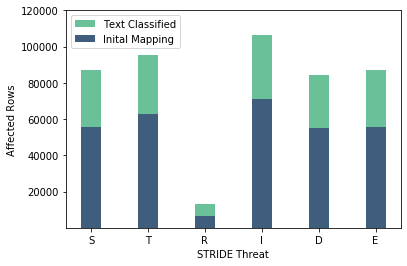

In [58]:
import numpy as np
width = 0.35 
N = 6
ind = np.arange(N)

p1 = plt.bar(ind, initial_stride_mapping, width, color='#3F5D7D')
p2 = plt.bar(ind, text_classification_stride_mapping, width,
             bottom=initial_stride_mapping, color='#6AC199')

plt.ylabel('Affected Rows')
plt.xlabel('STRIDE Threat')
plt.xticks(ind, ('S', 'T', 'R', 'I', 'D', 'E'))
plt.yticks(ticks=range(20000, 130000, 20000))
plt.legend((p2[0], p1[0]), ('Text Classified', 'Inital Mapping'), loc='upper left')
plt.show()

## 5. Table Reduction <a class="anchor" id="table_reduction"></a>
This last step shows how to reduce the dataset based on several selected attributes. All possible combinations of these attributes are taken into account and the desired values are extracted from the data set.

### 5.A. Attribute Encoding <a class="anchor" id="attribute_encoding"></a>

In [59]:
df.loc[df['cvssV2_access_vector'] == 'NETWORK','selection_access_vector'] = "Network"
df.loc[df['cvssV2_access_vector'] == 'LOCAL','selection_access_vector'] = "Local"
df.loc[df['cvssV2_access_vector'] == 'ADJACENT_NETWORK','selection_access_vector'] = "Network"

df['selection_authentication'] = False
df.loc[(df['cvssV2_authentication'] == 'SINGLE') | (df['cvssV2_authentication'] == 'MULTIPLE'), 'selection_authentication'] = True

df['selection_affected_resource'] = False
df.loc[df['cwe_affected_resources'].astype(str).str.contains("System Proces"), 'selection_affected_resource'] = "Process"
df.loc[df['cwe_affected_resources'].astype(str).str.contains("File or Directory"), 'selection_affected_resource'] = "File System"
df.loc[df['cwe_affected_resources'].astype(str).str.contains("Memory"), 'selection_affected_resource'] = "Memory"

df['selection_language_compiled'] = False
df['selection_language_interpreted'] = False
df['selection_language_web'] = False
df['selection_language_jit_compiled'] = False

df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("'C'"), 'selection_language_compiled'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("C++", regex=False), 'selection_language_compiled'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("Assembly"), 'selection_language_compiled'] = True

df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("Python", regex=False), 'selection_language_interpreted'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("Ruby", regex=False), 'selection_language_interpreted'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("JavaScript", regex=False), 'selection_language_interpreted'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("Perl", regex=False), 'selection_language_interpreted'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("Interpreted", regex=False), 'selection_language_interpreted'] = True

df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("PHP", regex=False), 'selection_language_web'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("ASP.NET", regex=False), 'selection_language_web'] = True

df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("C#", regex=False), 'selection_language_jit_compiled'] = True
df.loc[df['cwe_applicable_platforms_language'].astype(str).str.contains("Java", regex=False), 'selection_language_jit_compiled'] = True

df['selection_technology_web'] = False
df['selection_technology_database'] = False

df.loc[df['cwe_applicable_platforms_technology'].astype(str).str.contains("Database", regex=False), 'selection_technology_database'] = True
df.loc[df['cwe_applicable_platforms_technology'].astype(str).str.contains("Web", regex=False), 'selection_technology_web'] = True
df.loc[df['cwe_applicable_platforms_paradigm'].astype(str).str.contains("Web", regex=False), 'selection_technology_web'] = True

### 5.B. Generate Table <a class="anchor" id="generate_table"></a>

In [60]:
stride_columns = ['S', 'T', 'R', 'I', 'D', 'E']
generated_table = {}

table_row = {
    'access_vector':'',
    'user_access':'',
    'authentication':'',
    'language':'',
    'technology':'',
    'affected_rows':0,

}

i =0
for access_vector in ['Local', 'Network', 'Unknown']:
    for authentication in ['True', 'False', 'Unknown']:
        for language in ['selection_language_compiled', 'selection_language_interpreted', 'selection_language_web', 'selection_language_jit_compiled', 'Unknown']:
            for technology in ['selection_technology_web', 'selection_technology_database', 'Unknown']:
                new_row = table_row.copy()

                access_vector_kw = access_vector.replace('Unknown','')
                authentication_kw = authentication.replace('Unknown','')
                if language == 'Unknown' and technology == 'Unknown':
                    sub_df = df[(df['selection_access_vector'].astype(str).str.contains(access_vector_kw))
                          & (df['selection_authentication'].astype(str).str.contains(authentication_kw))]
                elif language == 'Unknown':
                    sub_df = df[(df['selection_access_vector'].astype(str).str.contains(access_vector_kw))
                              & (df['selection_authentication'].astype(str).str.contains(authentication_kw))
                              & (df[technology] == True)]
                elif technology == 'Unknown':
                    sub_df = df[(df['selection_access_vector'].astype(str).str.contains(access_vector_kw))
                              & (df['selection_authentication'].astype(str).str.contains(authentication_kw))
                              & (df[language] == True)]
                else:
                    sub_df = df[(df['selection_access_vector'].astype(str).str.contains(access_vector_kw))
                              & (df['selection_authentication'].astype(str).str.contains(authentication_kw))
                              & (df[language] == True)
                              & (df[technology] ==True)]

                new_row['affected_rows'] = len(sub_df)
                new_row['access_vector'] = access_vector
                new_row['authentication'] = authentication
                new_row['language'] = language
                new_row['technology'] = technology

                cwe_list = zip(sub_df[['cwe_id','cve_id']].groupby(by='cwe_id').count().sort_values(by='cve_id').index.values , sub_df[['cwe_id','cve_id']].groupby(by='cwe_id').count().sort_values(by='cve_id').values/len(sub_df))
                cwe_list_unpacked = []
                dict_id = 0

                for l in cwe_list:
                        cwe_id = l[0]

                        threats = {}
                        for threat in 'STRIDE':
                            if len(sub_df[(sub_df['cwe_id'] == cwe_id)]) > 0:
                                threats[threat] = len(sub_df[(sub_df['cwe_id'] == cwe_id)
                                        &(sub_df[threat]==True)])/len(sub_df[(sub_df['cwe_id'] == cwe_id)])
                            else:
                                threats[threat] = 0
                        base = sub_df[sub_df['cwe_id'] == cwe_id].cvssV2_base_score.mean()
                        impact = sub_df[sub_df['cwe_id'] == cwe_id].cvssV2_impact_score.mean()
                        exploitability = sub_df[sub_df['cwe_id'] == cwe_id].cvssV2_exploitability_score.mean()

                        cwe_list_unpacked.append([l[0],l[1][0], threats['S'], threats['T'], threats['R'], threats['I'], threats['D'], threats['E'], base, impact, exploitability])

                sorted_cwe_list = sorted(cwe_list_unpacked, key = lambda x: x[1], reverse=True)
                new_row['cwe_list'] = list(sorted_cwe_list)

                generated_table[i] =new_row
                i+= 1

In [61]:
selection_table = pd.DataFrame.from_dict(generated_table, orient='index')

In [62]:
selection_table.sample(5)

,access_vector,user_access,authentication,language,technology,affected_rows,cwe_list
128,Unknown,,Unknown,selection_language_web,Unknown,800,"[[434.0, 0.59375, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0..."
96,Unknown,,True,selection_language_web,selection_technology_web,242,"[[434.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 6...."
77,Network,,Unknown,selection_language_compiled,Unknown,17562,"[[119.0, 0.6514064457351099, 1.0, 1.0, 0.0, 1...."
26,Local,,False,selection_language_jit_compiled,Unknown,592,"[[362.0, 0.660472972972973, 0.0, 1.0, 0.0, 1.0..."
1,Local,,True,selection_language_compiled,selection_technology_database,0,[]
